# Comp Task

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv('UsArrests.csv', index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


# Exploring the data

In [416]:
# summarise properties of the data and the dataset
print(df.shape)
print(df.dtypes)
print(df.info())

(50, 4)
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB
None


We see we have continuous numerical variables except "City" which is now our Index

In [417]:
# summarise the statistical properties of the columns:
print(df.describe())

       Murder  Assault  UrbanPop   Rape
count  50.000   50.000    50.000 50.000
mean    7.788  170.760    65.540 21.232
std     4.356   83.338    14.475  9.366
min     0.800   45.000    32.000  7.300
25%     4.075  109.000    54.500 15.075
50%     7.250  159.000    66.000 20.100
75%    11.250  249.000    77.750 26.175
max    17.400  337.000    91.000 46.000


- the mean murder rate is 7.79 per 100,000 residents, with a standard deviation of 4.36
- the mean assault rate is 170.76 per 100,000 residents, with a standard deviation of 83.34
- the mean percentage of the population living in urban areas is 65.55%, with a standard deviation of 14.38% 
- the mean rape rate is 21.23 per 100,000 residents, with a standard deviation of 9.39

In [418]:
# Check for missing values
print(df.isnull().sum())
print(df.duplicated().sum())

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64
0


No imputation required seeing as we have no missing values

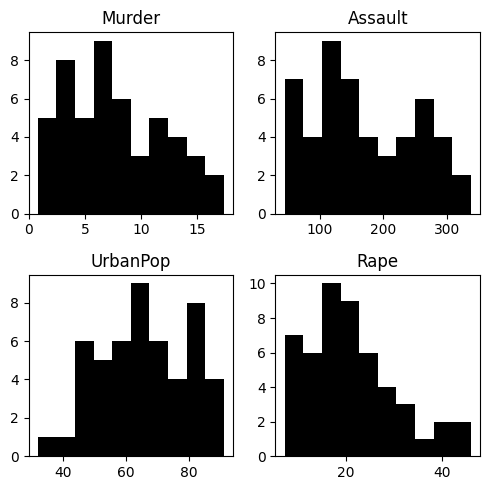

In [419]:
# visualise the distribution of the observations for each feature
histograms = df.hist(color='black', grid=False, figsize=(5, 5)) 
plt.tight_layout()
plt.show()

The histograms show that the murder, assault, and rape rates seem to be skewed distributions and the percentage of the population living in urban areas seems normally distributed

# Correlation Analysis

We demonstrate the use of Seaborn's heatmap, using a mask to remove the top triangular half of correlations, as these are repeats.

<Axes: >

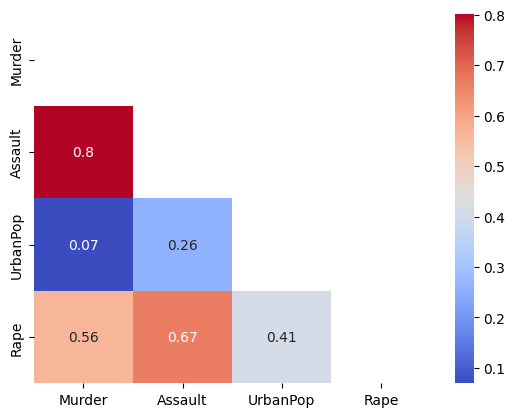

In [420]:
corr_df = df.corr()
labels = corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, annot=True , mask=mask_ut, cmap="coolwarm")

The correlation matrix shows that there is a strong positive correlation between the murder and assault rates, and a moderate positive correlation between the assault and rape rates while there is no negative correlated variables

Urban population rate shows weak correlation to the other variables, with the exception of rape rates, with which it has some level of correlation, albeit low

We can also explore the relationship between the data variables using scatter plots. There seems to be some clustering for the Murder, Assault and Rape distributions

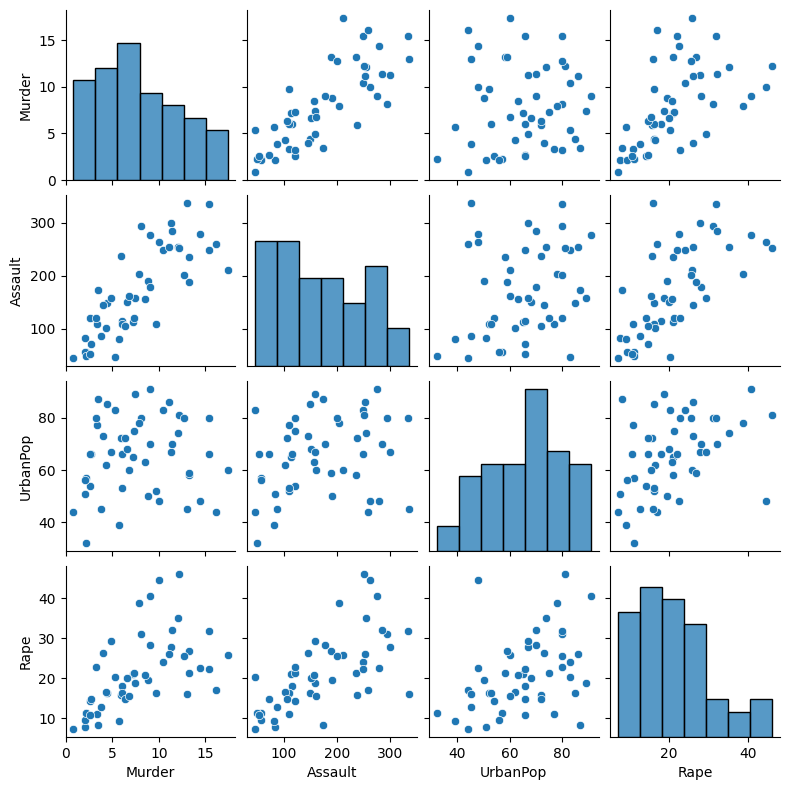

In [421]:
# Create scatterplots
sns.pairplot(df, height=2)
plt.show()

Given the high correlation between Assault, Murder, Rape, the data is a good candidate for PCA optimisation

## PCA

Principal Components Analysis (PCA) is a method for finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these

In [422]:
X = df.values.squeeze()
cities = df.index

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


Let us first look at the PCA features importance

In [423]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


Now we can create a biplot to evaluate the directions of the projected observations and magnitude of features variance

In [424]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors

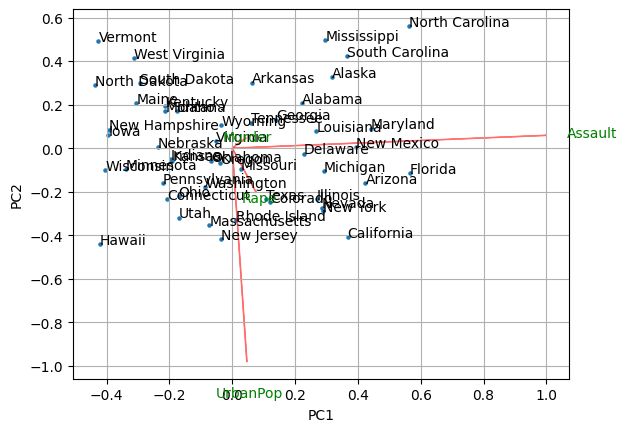

In [425]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels))
plt.show()

Looking at the features importance as well as the above biplot, we see that the Assault has by far the highest importance in the first principle component, while Urban Pop for the second component: if we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

Due to this, scaling of our variables becomes important for our analysis
### Scaling the data

We standardise the data so that some features do not swamp the others.

In [426]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


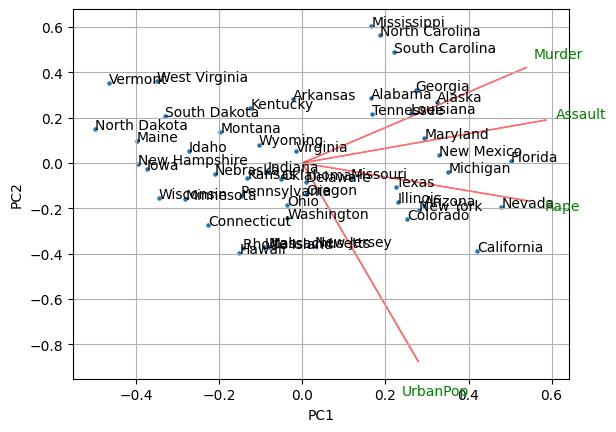

In [427]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

The observations that are clustered together in the biplot are more similar to each other in terms of their variable values. For example, the states of Mississipi, North Carolina and South Carolina are all located in the top-right quadrant of the biplot, which suggests that they have higher rates of Murder, Assault, and Rape, and lower rates of UrbanPop compared to the other cities

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the the different features cluster together in roughly 2 groups

In [428]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now after scaling, we see that most of the variables contribute fairly evenly, with only some with low importance.

The output shows that the first principal component is a combination of all the variables, with the highest loading on Assault and Rape. 
The second principal component has a high loading on Urban pop and a lower loading on Assault and Rape.

Text(0.5, 1.0, 'Cumulative Explained Variance')

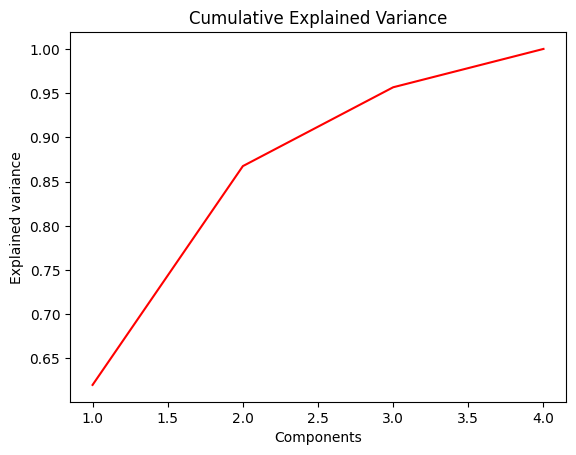

In [429]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

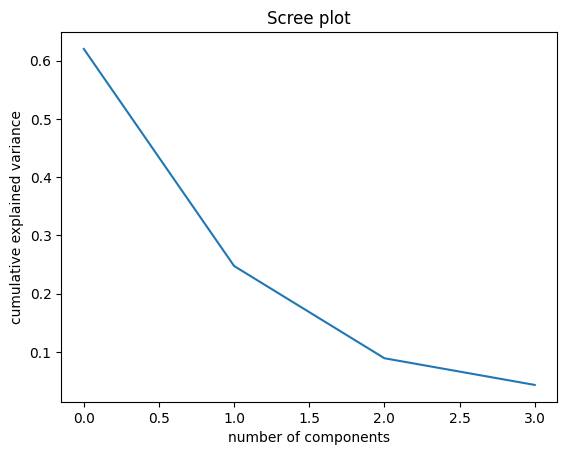

In [430]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 principal components together explain almost 90% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction.

In [431]:
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


We will now proceed with the application of two clustering techniques and an analysis of the clusters they generate

# Hierarchical clustering

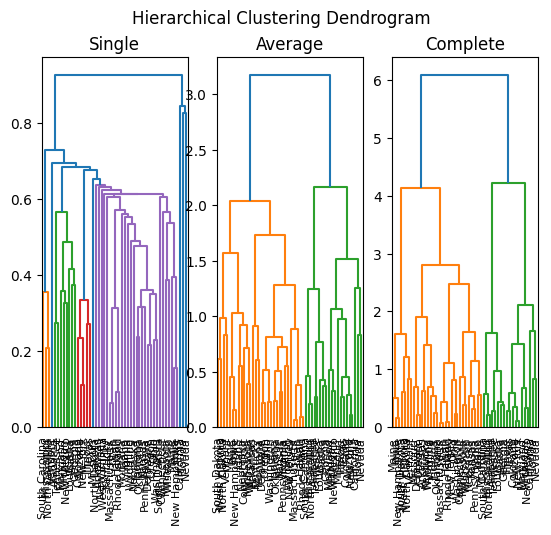

In [432]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

choosing complete linkage which separates into 2 distinct clusters with the highest vertical height of lines which corresponds to the euclidean distance between clusters.

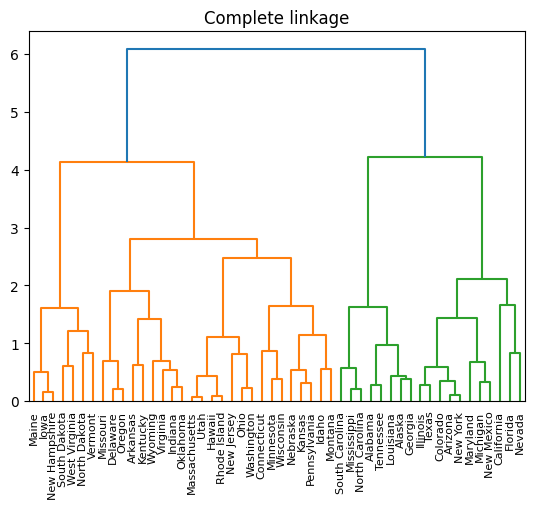

In [433]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

### K-means clustering

K-means requires specifying K in advance.

We can plot the elbow curve and perform a silhouette scoring to verify k

c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

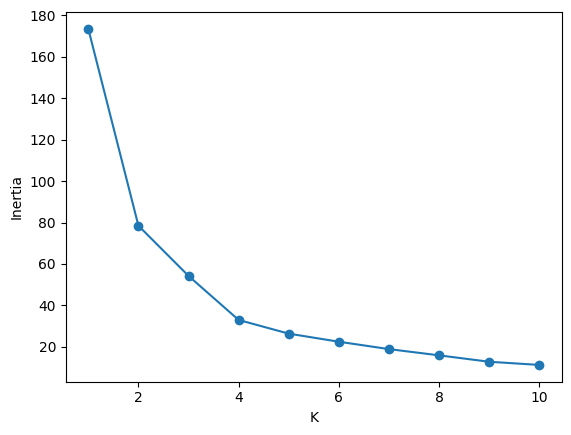

In [434]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=500)
    kmeans.fit(pca_df)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled data set
elbow_Kmeans(pca_df)

The elbow shows the optimum k value between 2 and 4, performing silhouette scoring can shed further light on the optimal k 

c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


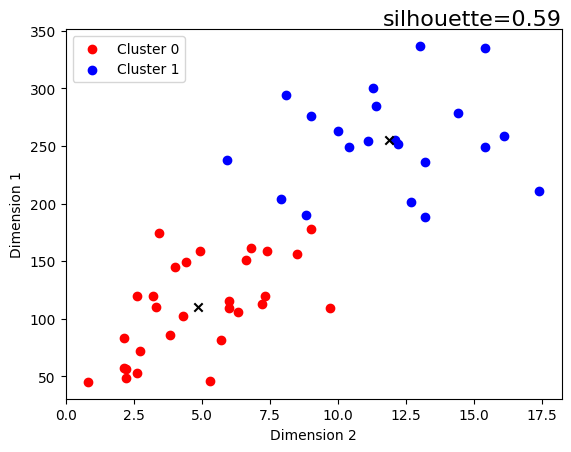

c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


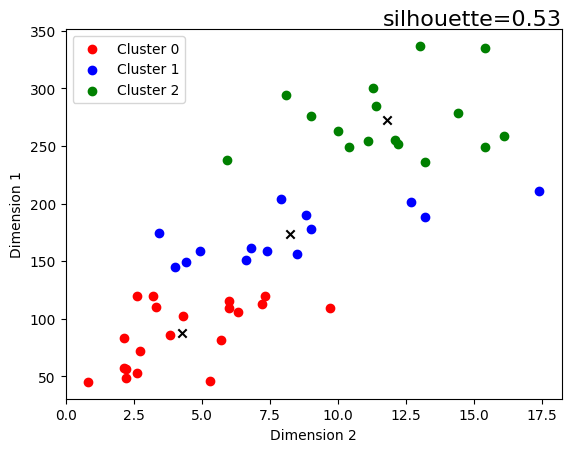

c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


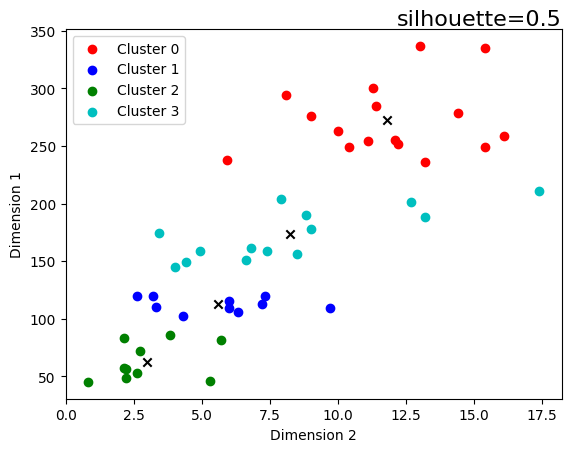

In [435]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Dimension 2')
    plt.ylabel('Dimension 1')
    plt.legend()
    plt.show()

for k in range(2,5):
  scatter_Kmeans(X, k, r=0)

The silhouette score suggests the actual optimal clustering is 2

For our analysis, K will be set to 2 based on the dendograms, PCA biplot, silhouette score. 

A visualisation of the clusters is shown in the figure below

c:\Users\dfcca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


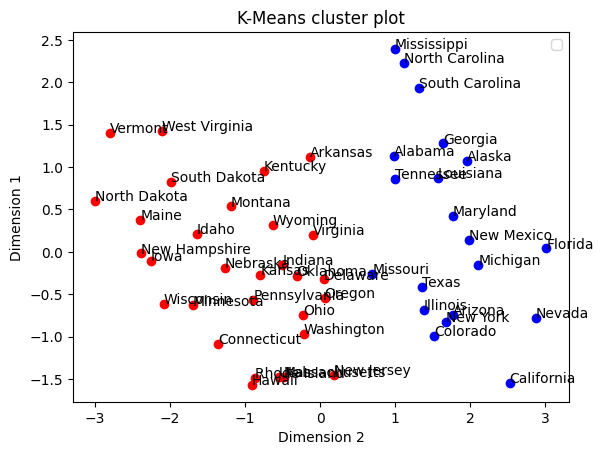

In [436]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dimension 2")
ax.set_ylabel("Dimension 1")
ax.legend()

In [437]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]


print("Group 0: {}\n\n".format([x for x in group0]))
print("Group 1: {}\n\n".format([x for x in group1]))

Group 0: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


Group 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']




With boxplots we can highlight the distribution variance for our variables in each cluster / group of Cities

<Axes: xlabel='cluster labels', ylabel='Assault'>

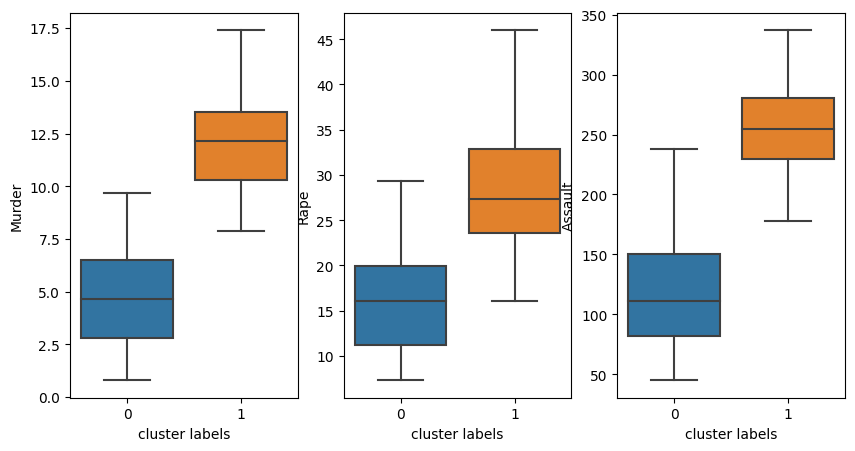

In [438]:
df['cluster labels']=cluster_labels

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(10,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

From the above we can clearly see the differences in the Murder, Rape and Assault rates between the cities in cluster 0, safer cities, and those in cluster 1, unsafer cities